# Import Required Libraries 📚

In [1]:
# Common
import os
import cv2
import numpy as np
import pandas as pd
# Data 
import tarfile
from tqdm import tqdm
from glob import glob
# Data Visuaalization
import matplotlib.pyplot as plt
# Model
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Dense,Flatten,Softmax,ReLU,GlobalAveragePooling2D,Input,Lambda,Conv2D,MaxPool2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

2024-03-11 18:23:21.790583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 18:23:21.790688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 18:23:21.923709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Faces

In [2]:
path = '/data/'
images_path = [f'{path}/img_{c}.png' for c in range(len(os.listdir(path)))]

# Load Targets

In [3]:
file = open('/kaggle/input/cropped-faces-from-lfw-dataset/target.txt','r')
y = file.readlines()

# Read all images

In [4]:
def load_images(paths):
    images = []
    for path in tqdm(paths):
        img = cv2.imread(path)
        images.append(img)
    return images

In [5]:
X =  load_images(images_path)

100%|██████████| 13233/13233 [02:12<00:00, 100.09it/s]


# Encoder for targets

In [6]:
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)

# Function to make image paires for **Modeling**

In [7]:
def make_pairs(images, labels,path):
    np.random.seed(99)
    try:
        path = path if path[-1] == '/' else path+'/'
        os.mkdir(path+"images")
        os.mkdir(path+"images/1")
        os.mkdir(path+"images/0")
    except:
        pass
    x,y,c = images[0].shape

    """
    Store pair of images as one image
    ---------------------------------
    ==> pairImages: list of two images
    ==> pairLabels: list if images are similar(1) or not(0)

    ==>pairImages the size is double number of given images, by build for each image similar pairs and negative pairs 'randomly'.


        params:
            images: array-like contain images data
            labels: array-like contain images label
            path  : place for saving data into it.
    """

#     pairImages = [] #Semilar Images in one list like [image1,image2] ==> same class
#     pairLabels = [] #Label for lists if it positive or negative pairs

    numClasses = len(np.unique(labels)) #Number of classes
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)] # list contain indexs for images for each class
    counter=0
    # loop over all images
    for idxA in tqdm(range(len(images))):
        tempImage = np.zeros((x,y*2,c),dtype=np.float32)
        
    #  idxA is for image index

        currentImage = images[idxA].astype(np.float32) # Select image using index
        label = labels[idxA] # Select the label


        idxB = np.random.choice(idx[label])# randomly pick an index that belongs to the *same* class
        posImage = images[idxB].astype(np.float32) # Select image using index



        tempImage[:,:x,:] = currentImage
        tempImage[:,x:,:] = posImage
        cv2.imwrite(f'{path}images/1/_{counter}.png',tempImage)


        negIdx = np.where(labels != label)[0]# Select list of indexs from differant class
        negImage = images[np.random.choice(negIdx)].astype(np.float32) #Select random image

        tempImage[:,:x,:] = currentImage
        tempImage[:,x:,:] = negImage
        cv2.imwrite(f'{path}images/0/_{counter}.png',tempImage)
        counter+=1

In [8]:
make_pairs(X,encoded_y,'/kaggle/working/')
del X
del encoded_y
del encoder

100%|██████████| 13233/13233 [01:31<00:00, 144.07it/s]


## Create list of images path

In [9]:
paths = [ f'/kaggle/working/images/0/{i}' for i in os.listdir('/kaggle/working/images/0')]
target= ['0']*len(paths)
temp = [ f'/kaggle/working/images/1/{i}' for i in os.listdir('/kaggle/working/images/1')]
paths.extend(temp)
target.extend(['1']*len(temp))
del temp
samples_num = len(paths)
print(samples_num)
print('*********')

26466
*********


## Book validation data

In [11]:
# Validation
validation_img = []
validation_tar = []
for i in range(int(np.ceil(samples_num * 0.03778))):
    index = np.random.randint(0,len(paths),1)
    validation_img.append(paths.pop(index[0]))
    validation_tar.append(target.pop(index[0]))
    
samples_num = len(paths)
print("Validation Size: ",len(validation_img))

Validation Size:  1000


In [12]:
print("Validation Size:",len(validation_tar))

df = pd.DataFrame({'data':validation_img,
                  'y':validation_tar })
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('val_output.csv',index=False)
val_samples_num = len(validation_img)

Validation Size: 1000


## Training data

In [13]:
print("Training Size:",samples_num)

df = pd.DataFrame({'data':paths,
                  'y':target })
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('output.csv',index=False)

Training Size: 25466


## Identify generator functions

In [14]:
def load_data(Train_df,idx,
              batch_size):
    df = pd.read_csv(Train_df, skiprows=idx*batch_size,
                  nrows=batch_size)
    x = df.iloc[:,0].values
    pairs=[]
    for im in x:
        Full_img = cv2.imread(im).astype(np.float32) / 255
        pairs.append([Full_img[:,:150,:],Full_img[:,150:,:]])
    pairs = np.array(pairs)
    y = df.iloc[:,-1]
    return ([pairs[:, 0], pairs[:, 1]], y.values)

In [15]:
def batch_generator(Train_df,batch_size,
                    steps):
    idx=1
    while True: 
        yield load_data(Train_df,idx-1,batch_size)## Yields data
        if idx<steps:
            idx+=1
        else:
            idx=1

## Modeling Structure 

In [16]:
def build_siamese_model(inputShape, embeddingDim=48):
    
    
    model = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
    for layer in model.layers[:-5]:
        layer.trainable = False
    x = GlobalAveragePooling2D()(model.output)
    out = Dense(256)(x)
    model = Model(model.input,out)

    return model

In [17]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [18]:
imgA = Input(shape=(150,150,3))
imgB = Input(shape=(150,150,3))
featureExtractor = build_siamese_model((150,150,3),100)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [20]:
# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256)                  1484601   ['input_1[0][0]',             
                                                          6          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

In [22]:
# Training data generaror 
batch_size = 500
my_training_batch_generator = batch_generator('output.csv', batch_size,np.ceil(samples_num/batch_size))

In [23]:
def val_batch_generator(Train_df,batch_size,
                    steps):
    idx=1
    while True: 
        yield load_data(Train_df,idx-1,batch_size)## Yields data
        if idx<steps:
            idx+=1
        else:
            break

In [24]:
# Validation data 
val_batch_size = 1000
my_val_batch_generator = val_batch_generator('val_output.csv', val_batch_size,np.ceil(val_samples_num/val_batch_size))
X_val,y_val = next(my_val_batch_generator)

In [25]:
print(len(X_val[0]),len(y_val))

1000 1000


In [26]:
from tensorflow.keras.callbacks import EarlyStopping
Early = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True)

In [27]:
his = model.fit(
    my_training_batch_generator,
    epochs=21,
    steps_per_epoch=int(samples_num / batch_size),
    verbose=1,validation_data=(X_val,y_val),callbacks=[Early])

Epoch 1/21


I0000 00:00:1710181744.027014     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 250s 3s/step - loss: 0.5860 - accuracy: 0.7054 - val_loss: 0.5389 - val_accuracy: 0.7460
Epoch 2/21
50/50 [==============================] - 226s 3s/step - loss: 0.5363 - accuracy: 0.7195 - val_loss: 0.4986 - val_accuracy: 0.7520
Epoch 3/21
50/50 [==============================] - 131s 3s/step - loss: 0.5059 - accuracy: 0.7297 - val_loss: 0.4787 - val_accuracy: 0.7670
Epoch 4/21
50/50 [==============================] - 131s 3s/step - loss: 0.4833 - accuracy: 0.7510 - val_loss: 0.4774 - val_accuracy: 0.7710
Epoch 5/21
50/50 [==============================] - 131s 3s/step - loss: 0.4690 - accuracy: 0.7679 - val_loss: 0.4668 - val_accuracy: 0.7820
Epoch 6/21
50/50 [==============================] - 131s 3s/step - loss: 0.4521 - accuracy: 0.7920 - val_loss: 0.4651 - val_accuracy: 0.7810
Epoch 7/21
50/50 [==============================] - 131s 3s/step - loss: 0.4351 - accuracy: 0.8059 - val_loss: 0.4385 - val_accuracy: 0.7920
Epoch 8/21
50/50 [======

<Axes: >

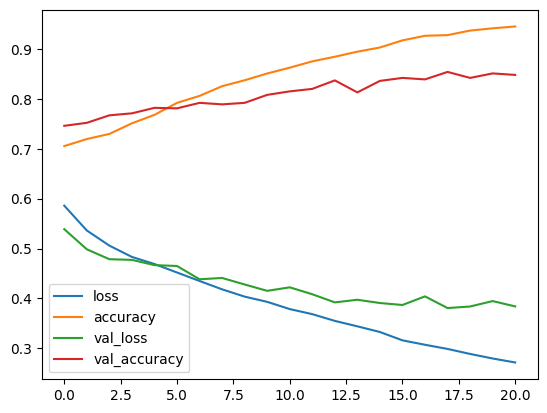

In [28]:
pd.DataFrame(model.history.history).plot(kind='line')

In [29]:
model.save('model',save_format='tf')

In [30]:
model.save('base model.h5')

In [56]:
model.save_weights('base model weights.h5')

In [31]:
from sklearn.metrics import classification_report

In [32]:
result = model.predict(X_val)

32/32 [==============================] - 5s 138ms/step


In [38]:
def apply_threshold(predicted,threshold=0.5):
    """
    return 0,1 for each row by applying threshold.
    
    param:
        predicted: array-like for predected result USUALLY between 0 and 1
        threshold: float number represent the min value for 1 and max value for 0
    """
    temp = np.where(predicted.round(2) >= threshold,1,0)
    return temp

In [54]:
pred1 = apply_threshold(result,0.5)

In [52]:
print('Result: ',[i[0] for i in pred1[:10]])

Result:  [1, 1, 0, 0, 0, 0, 0, 1, 0, 0]


In [59]:
print(classification_report(y_val,pred1))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       535
           1       0.92      0.73      0.81       465

    accuracy                           0.84      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.86      0.84      0.84      1000

